<img src="neid_thin.png" width="600"></img>

<h1><center>NEID Data Analysis Tutorial: Part 3 </center></h1>

<center><b>Author</b>: Arpita Roy (aroy@stsci.edu) | <b>Latest update</b>: June 21, 2021.</center>

--------------------------------------------------------------


## Table of contents
1. [Introduction](#intro)
2. [Open FITS File](#fits)
3. [Plot CCF](#plotspec)
4. [Shift CCF](#shiftccf)


### 1. Introduction <a class="anchor" id="intro"></a>
[NEID](https://neid.psu.edu/) is an extreme precision, high resolution spectrograph that is designed for exoplanet discovery and characterization. This is a beginner's guide to NEID data analysis. In this tutorial, we will look at the cross-correlation functions (CCFs) that yield the measurements of radial velocity (RV). 

It is important to understand how the NEID RVs are measured before you make scientific interpretations based on those RVs — since measurement techniques can have sensitivities and biases. NEID's core RV measurement technique, based on [cross-correlation with stellar masks](https://neid.ipac.caltech.edu/docs/NEID-DRP/algorithms.html#cross-correlation-based-rvs), has been tested over the last two decades and is very robust. However, the results are sensitive to the configuration of the cross-correlation algorithm and the mask that is used.

Let's start by importing all the libraries we will need.

In [1]:
# Import file handling libraries:
import os
from glob import glob

# Import numpy and matplotlib:
import numpy as np
import matplotlib.pyplot as plt

# Import astropy for fits handling:
from astropy.io import fits

# Import scipy for interpolation
from scipy.interpolate import interp1d

In [2]:
# You can set your plotting style of choice here
plt.style.use(['seaborn-darkgrid'])

### 2. Open FITS File <a class="anchor" id="fits"></a>
We have a sample observation of 51 Peg to look at. Let's open up the FITS file and explore its contents. Note the NEID file naming convention: neidL#_YYYYMMDDThhmmss.fits, where # is 0, 1, or 2 for the data level, and YYYYMMDDThhmmss is the timestamp corresponding to the beginning of the exposure. So this observation was taken on 7th June 2021, a little after 9am UT.

In [3]:
hdul = fits.open('neidL2_20210607T090003.fits')

FITS files contain both data and metadata (information about the data). For NEID, the L2 FITS file is data cube containing several extensions with data, and corresponding headers with metadata about the observation conditions and processing that has already been performed. You can get a quick view of what is in the FITS file like this:

In [4]:
hdul.info()

Filename: neidL2_20210607T090003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     746   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float32   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float32   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float32   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2253   (9216, 122)   float64   
 10  TELLURIC      1 ImageHDU        12   (9216, 122)   float64   
 11  SKY           1 ImageHDU         8   ()      
 12  CCFS          1 ImageHDU       515   (804, 122)   float64   
 13  ACTIVITY      1 BinTableHDU     41   15R x 12C   [10A, D,

The names of the extensions should give you a good idea of what data is contained in them. The one we will look at here is the `CCFS` extension with contains the cross correlation functions per order. The corresponding header has details about the algorithm configuration and the resulting measurements of the CCFs.

Let's extract the data and header from the `CCFS` extension.

In [5]:
ccf = hdul['CCFS'].data
head = hdul[0].header
ccfhead = hdul['CCFS'].header

print(ccf.shape)

(122, 804)


The CCF array has 122 orders (just like each extracted NEID spectrum), with each order array being 804 pixels wide. 

### 3. Plot CCF <a class="anchor" id="plotspec"></a>

First let's plot a single order.

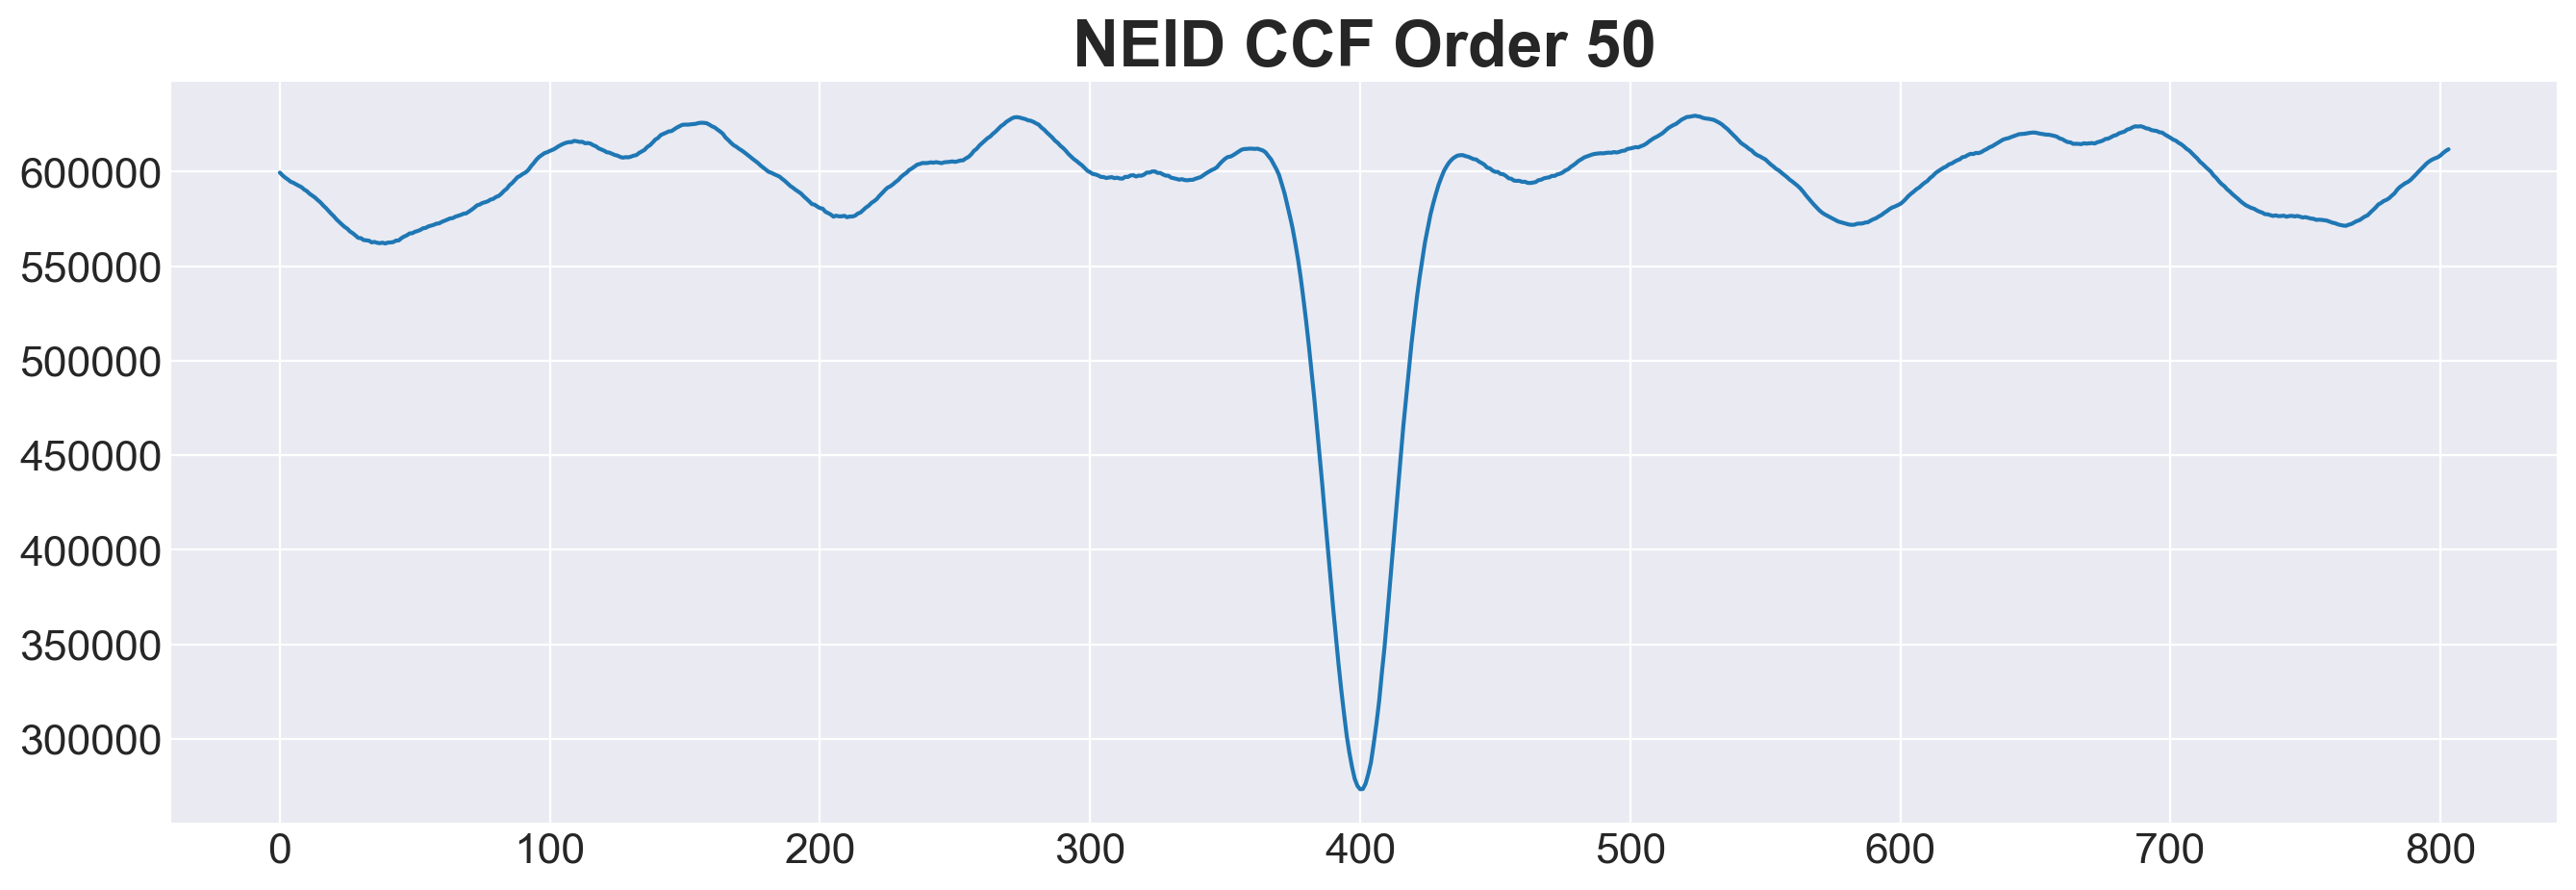

In [6]:
order = 50
fig = plt.subplots(figsize=(16,5))
plt.plot(ccf[order,:])
plt.title('NEID CCF Order {}'.format(order))
plt.show()

What are we looking at? As the stellar mask is shifted across the spectrum of this order, it happened to line up best around the 400th step causing the big dip in the CCF.

We haven't talked about the units of this plot yet. The y-axis is a representation of "CCF Strength" or how well the spectrum and mask line up at any given point on the x-axis. The x-axis is in velocity — the mask is shifted to different velocities to see if it matches up with the observed spectrum. The parameters of this velocity array are stored in the header. Let us retreive those and plot this order CCF with correct units.

In [7]:
# These are the header keywords we will need
ccfstart = float(ccfhead['CCFSTART'])
ccfstep = float(ccfhead['CCFSTEP'])
npixels = float(ccfhead['NAXIS1'])
gamma_rv = float(head['QRV'])

print('Start of x-axis velocity array:',ccfstart)
print('Step size of x-axis velocity array:',ccfstep)
print('Length of x-axis velocity array:',npixels)
print('Rough average velocity of star:',gamma_rv)  # --> Will be 0 for the Sun

Start of x-axis velocity array: -100.0
Step size of x-axis velocity array: 0.25
Length of x-axis velocity array: 804.0
Rough average velocity of star: -33.2443


In [8]:
velocity_loop = (np.arange(npixels)*ccfstep) + ccfstart + gamma_rv

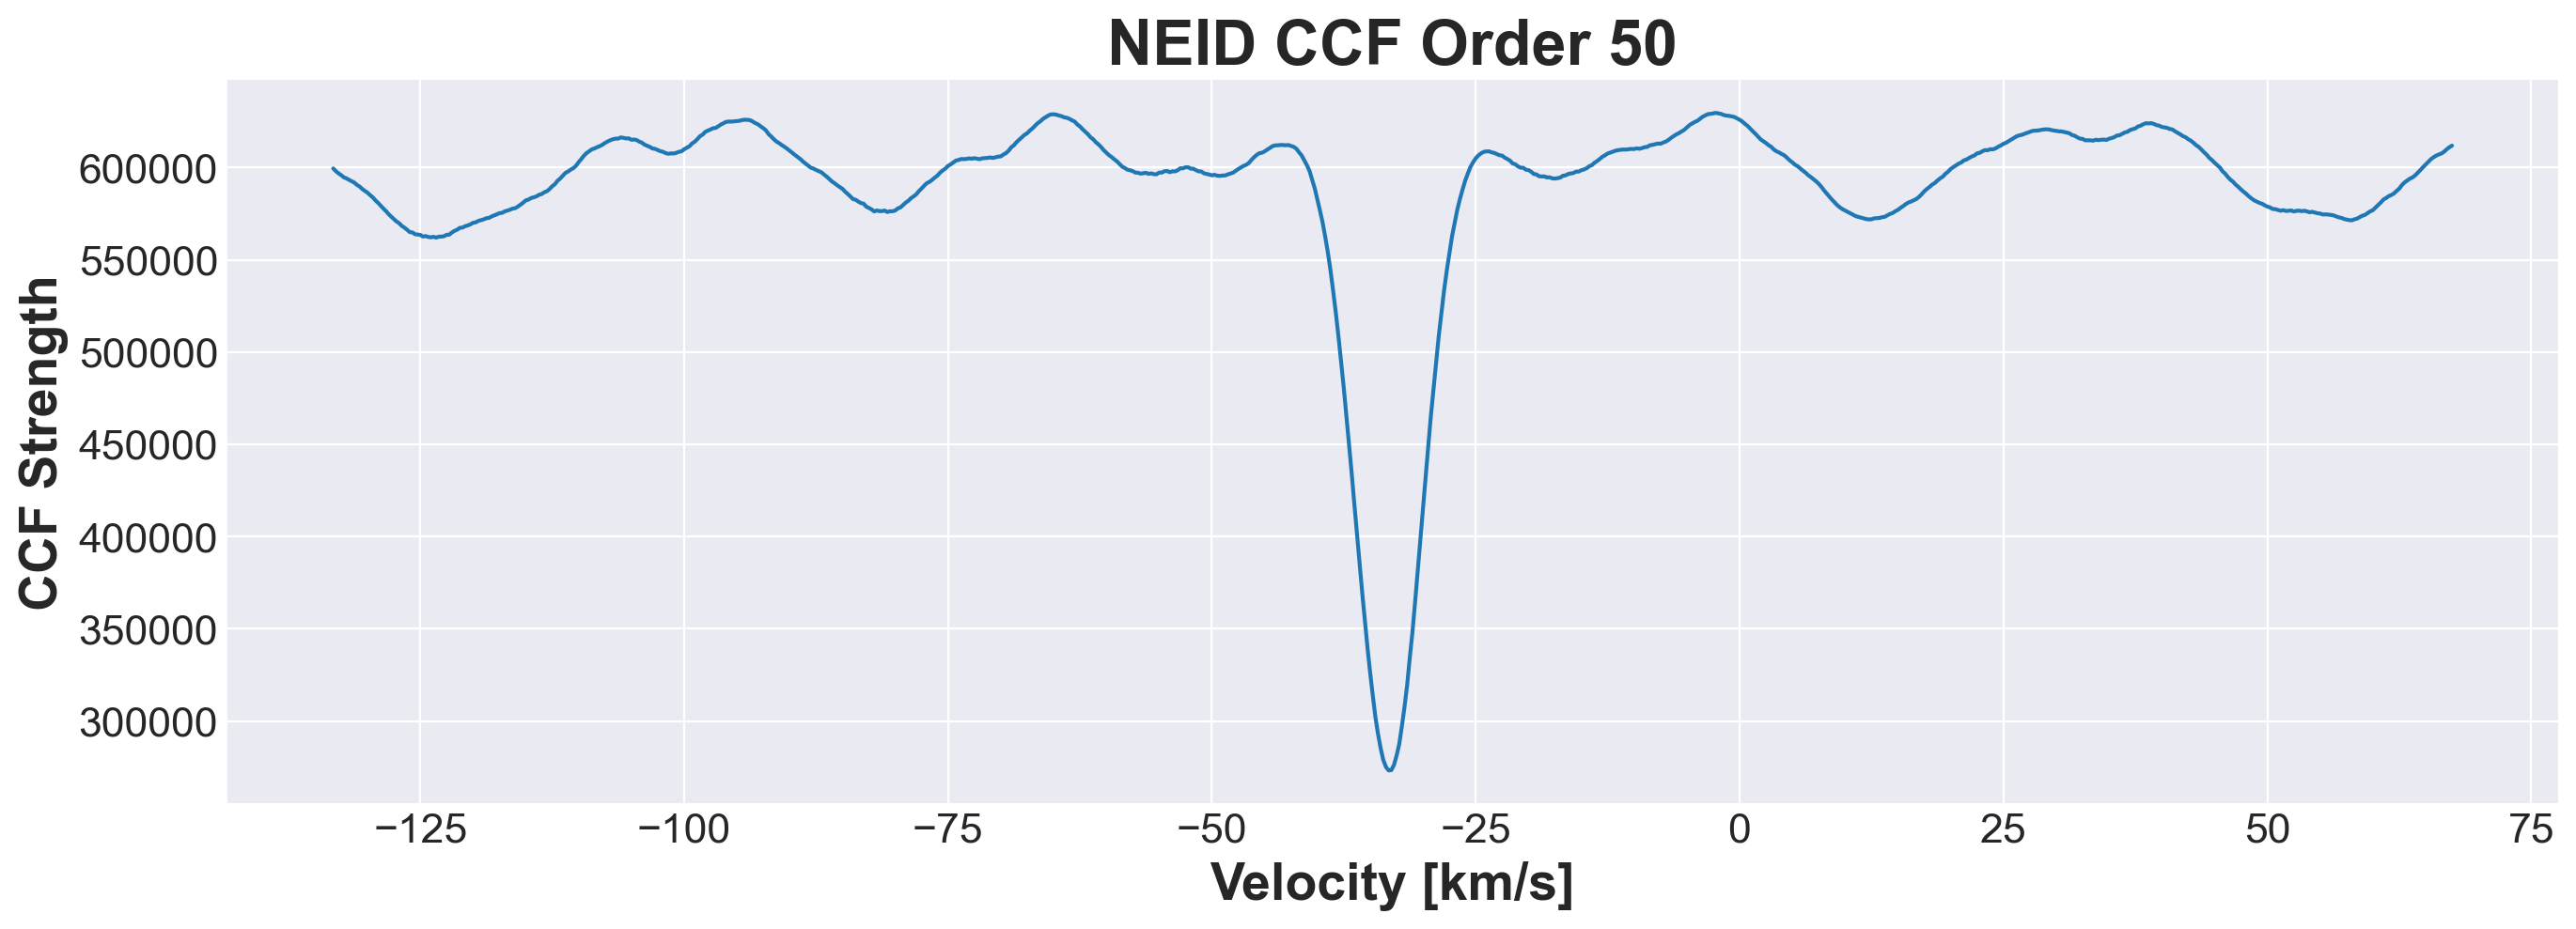

In [9]:
order = 50
fig = plt.subplots(figsize=(16,5))
plt.plot(velocity_loop,ccf[order,:])
plt.title('NEID CCF Order {}'.format(order))
plt.xlabel('Velocity [km/s]')
plt.ylabel('CCF Strength')
plt.show()

Let's zoom in.

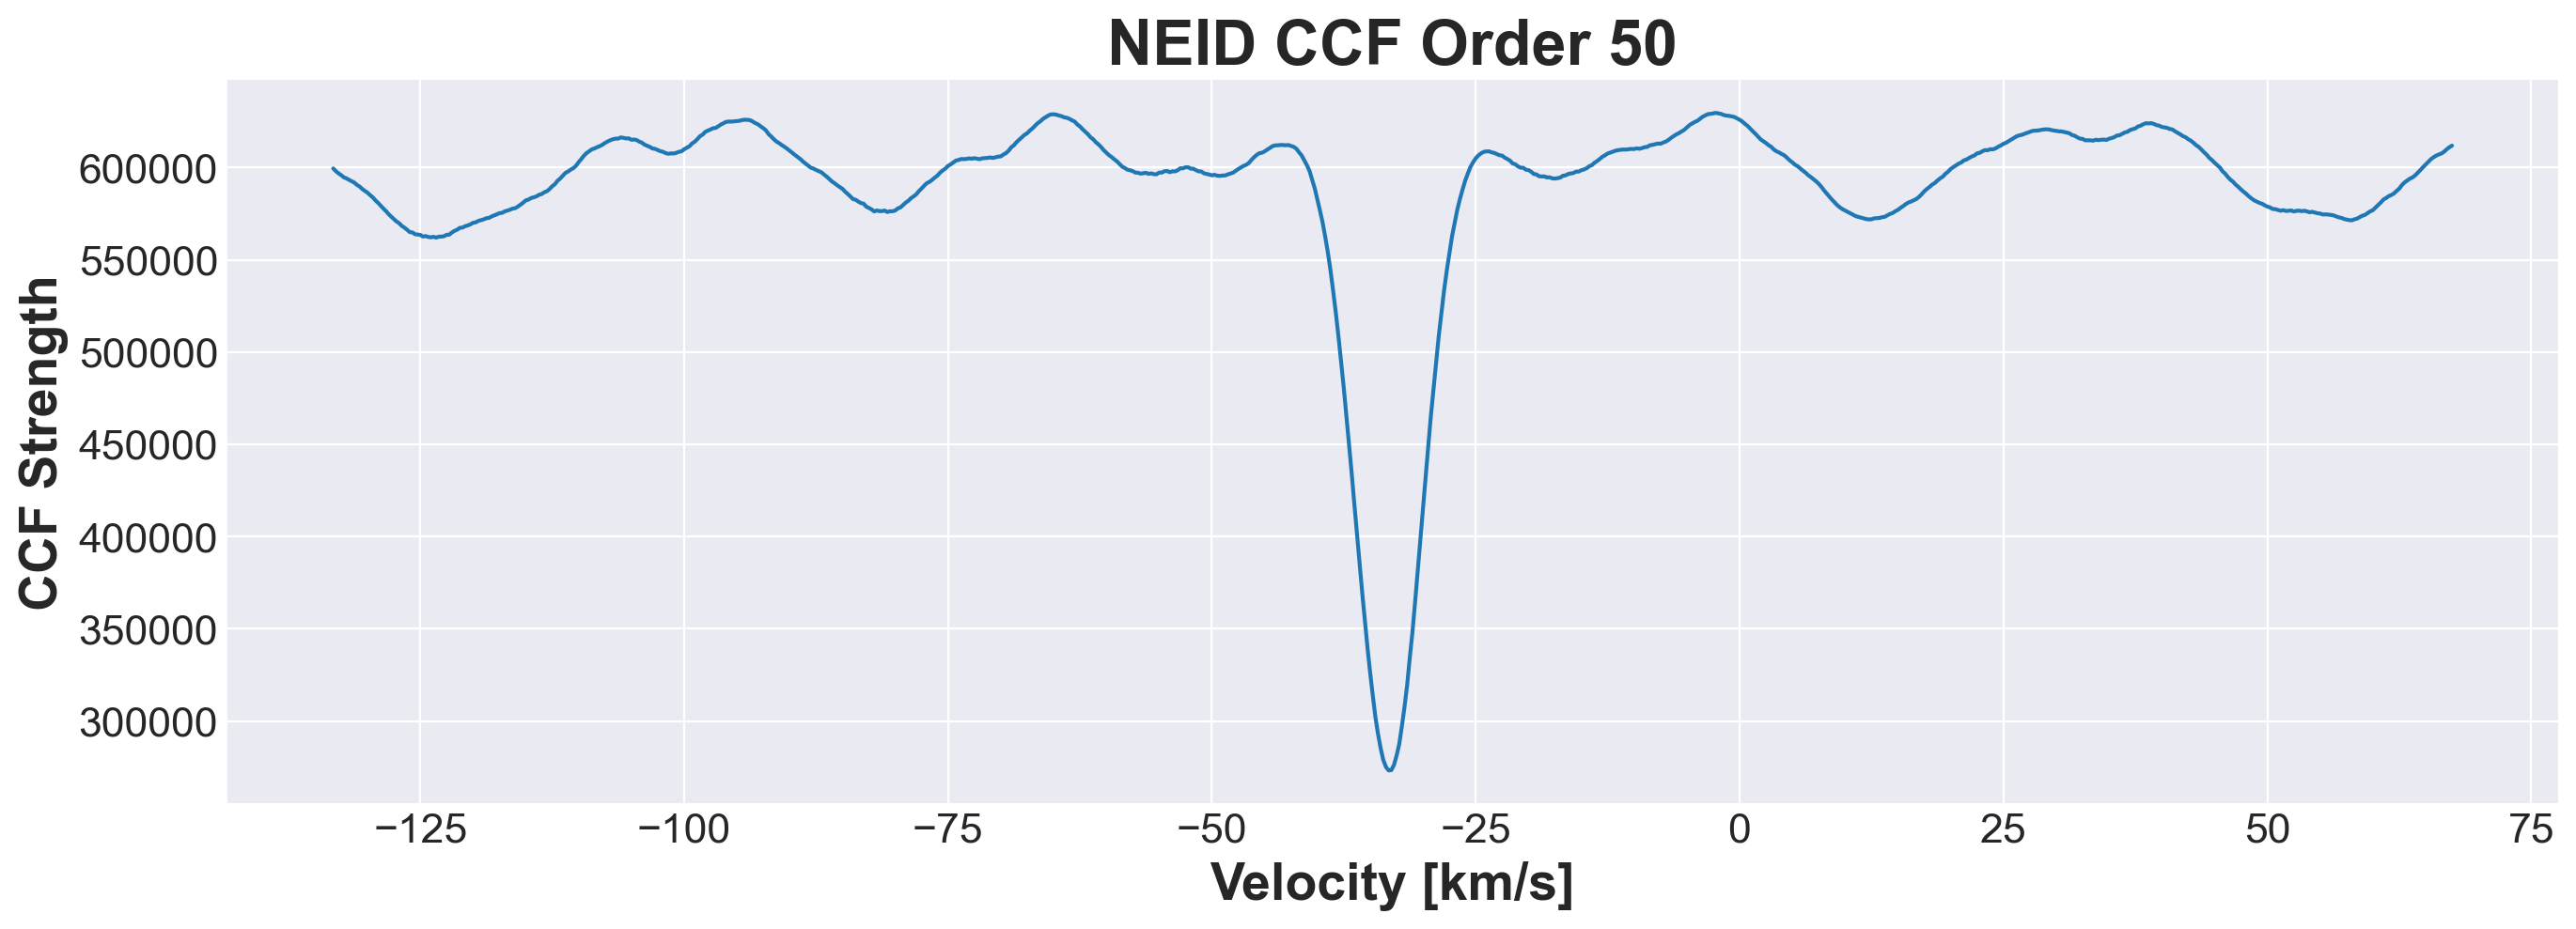

In [10]:
order = 50
fig = plt.subplots(figsize=(16,5))
plt.plot(velocity_loop,ccf[order,:])
plt.title('NEID CCF Order {}'.format(order))
plt.xlabel('Velocity [km/s]')
plt.ylabel('CCF Strength')
#plt.xlim(-50,-18)
plt.show()

Looks like the peak of the CCF is at approximately -33km/s. To precisely measure the RV, we would fit a Gaussian to this peak, and use the centroid of the Gaussian as our final answer for this order.

However, there are many orders to consider. Let's make a plot of all order CCFs to get a better sense.

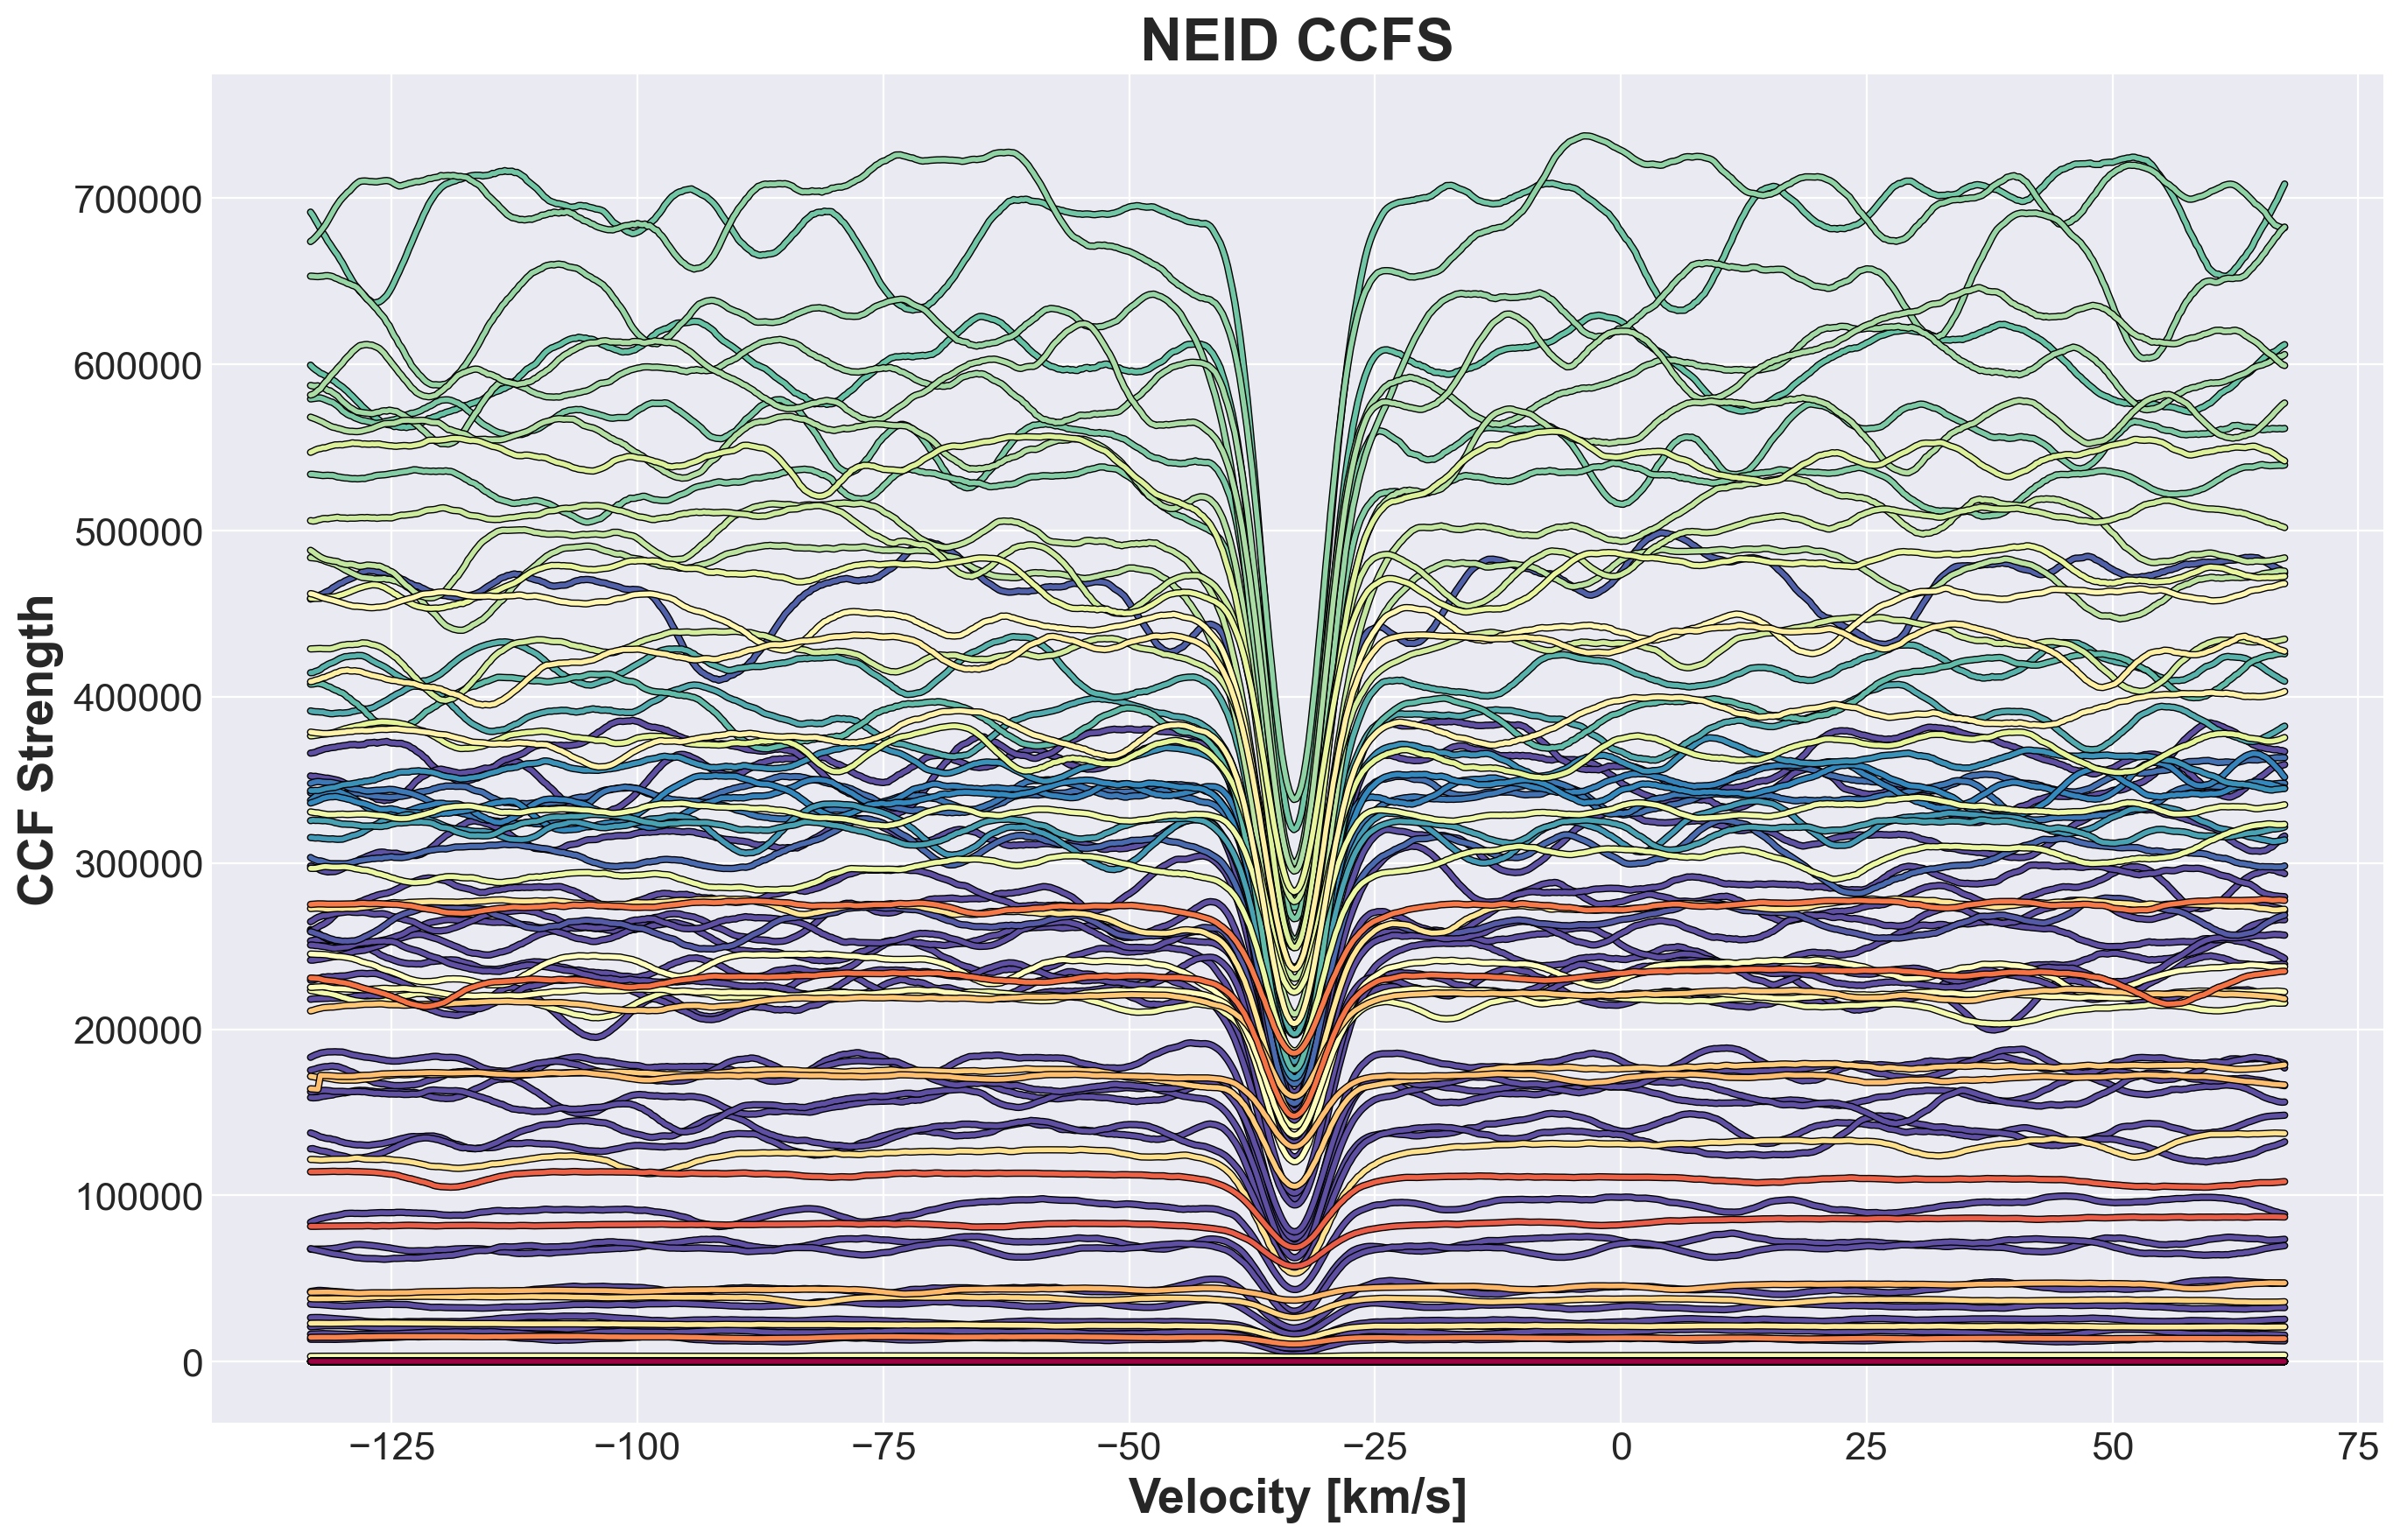

In [11]:
norders = ccf.shape[0]

# Sort out color map
cmap = plt.get_cmap('Spectral_r')
mycolors = cmap(np.linspace(-0.5, 1.2, norders))

fig, ax = plt.subplots(figsize=(16,10))

for order in range(norders):
    ax.plot(velocity_loop,ccf[order,:],c='black',lw=3)
    ax.plot(velocity_loop,ccf[order,:],c=mycolors[order], lw=2)

ax.set_title('NEID CCFS')
ax.set_xlabel('Velocity [km/s]')
ax.set_ylabel('CCF Strength')
#ax.set_xlim(-50,-16)
#ax.set_ylim(0,7.2e5)
plt.show()

Here are the CCFS of all the orders. Notice they have different strengths — this depends on the flux level in the spectrum, and number of lines in the cross-correlation mask. If you look back, you will see the summed CCF has a much higher strength as expected.

These are colored by average wavelength of the order, but note that order number (or wavelength) does not simply correlate with CCF strength.

What we usually want is one final answer for all the orders. To do this, we will add up all the order CCFS to produce a final summed CCF for the epoch. Let's calculate and plot that.

In [12]:
ccfsum = np.nansum(ccf, axis=0)

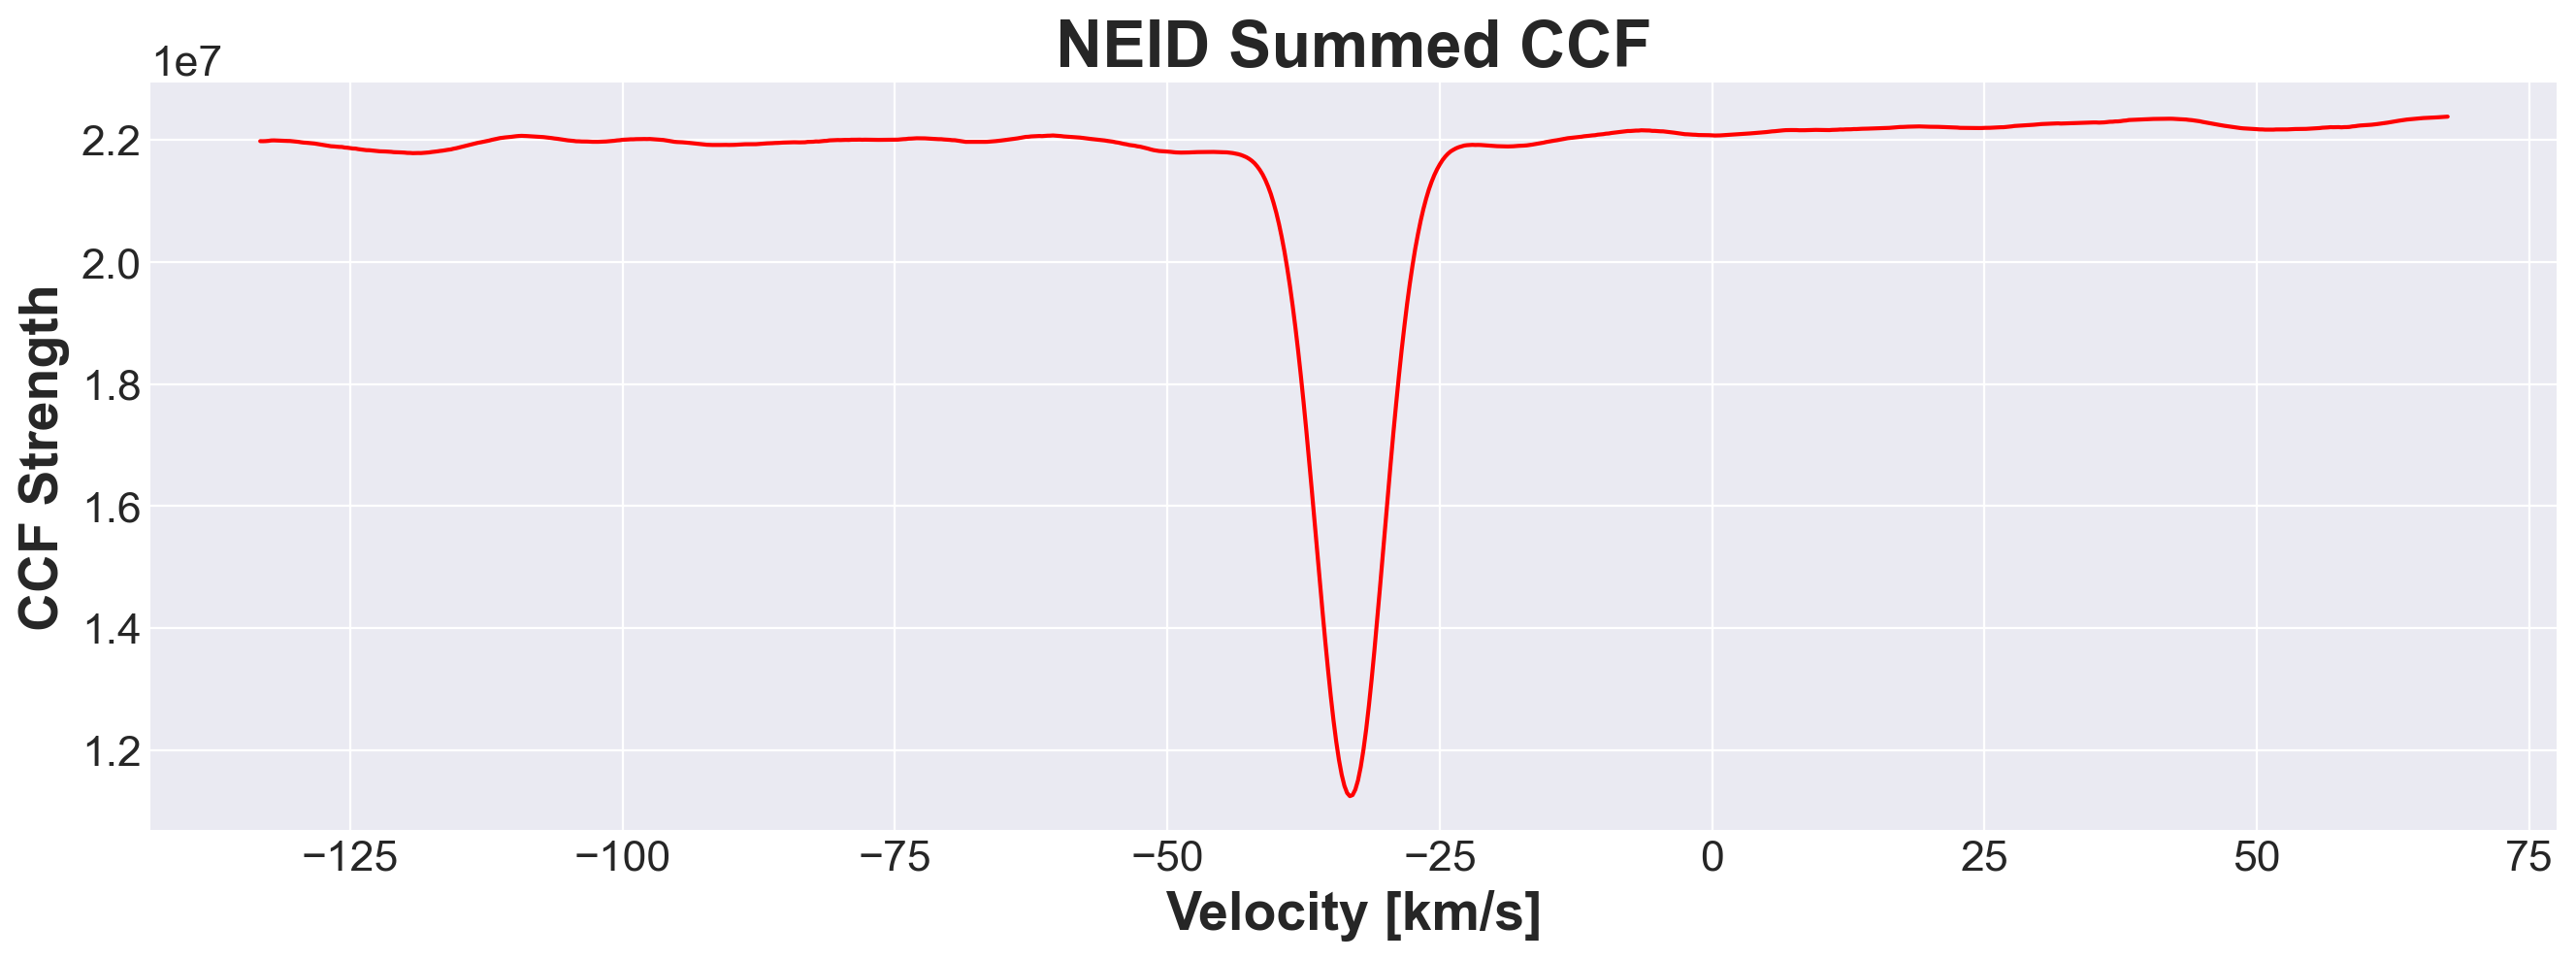

In [13]:
fig = plt.subplots(figsize=(16,5))
plt.plot(velocity_loop,ccfsum,c='r')
plt.title('NEID Summed CCF')
plt.xlabel('Velocity [km/s]')
plt.ylabel('CCF Strength')
#plt.xlim(-50,-18)
plt.show()

Looks very similar, but is much cleaner than individual order CCFs. In the pipeline, there is one additional step of weighting the CCFs to try and correct out any variations in the overal spectral energy distribution (SED) due to observing conditions. We will call this `ccfmod`, or modified CCF — let's calculate this.

In [14]:
# These are fixed numbers for NEID based on the echelle grating 
# and the orders we are extracting in V1.0 of the pipeline.
# Don't change these!
ordmin = 57
ordmax = 169
bluest_order = 173
ccfwt = np.zeros(norders)
ccfsum = np.nansum(ccf, axis=0)

for trueorder in range(ordmin,ordmax+1,1):
    raworder = bluest_order - trueorder
    ccfwt[raworder] = ccfhead['CCFWT%03i'%trueorder]

# CCF Reweighting
ccfmod = np.nansum((ccf.T * ccfwt).T, axis=0)
rescale = np.nansum(ccfsum)/np.nansum(ccfmod)
ccfmod *= rescale   

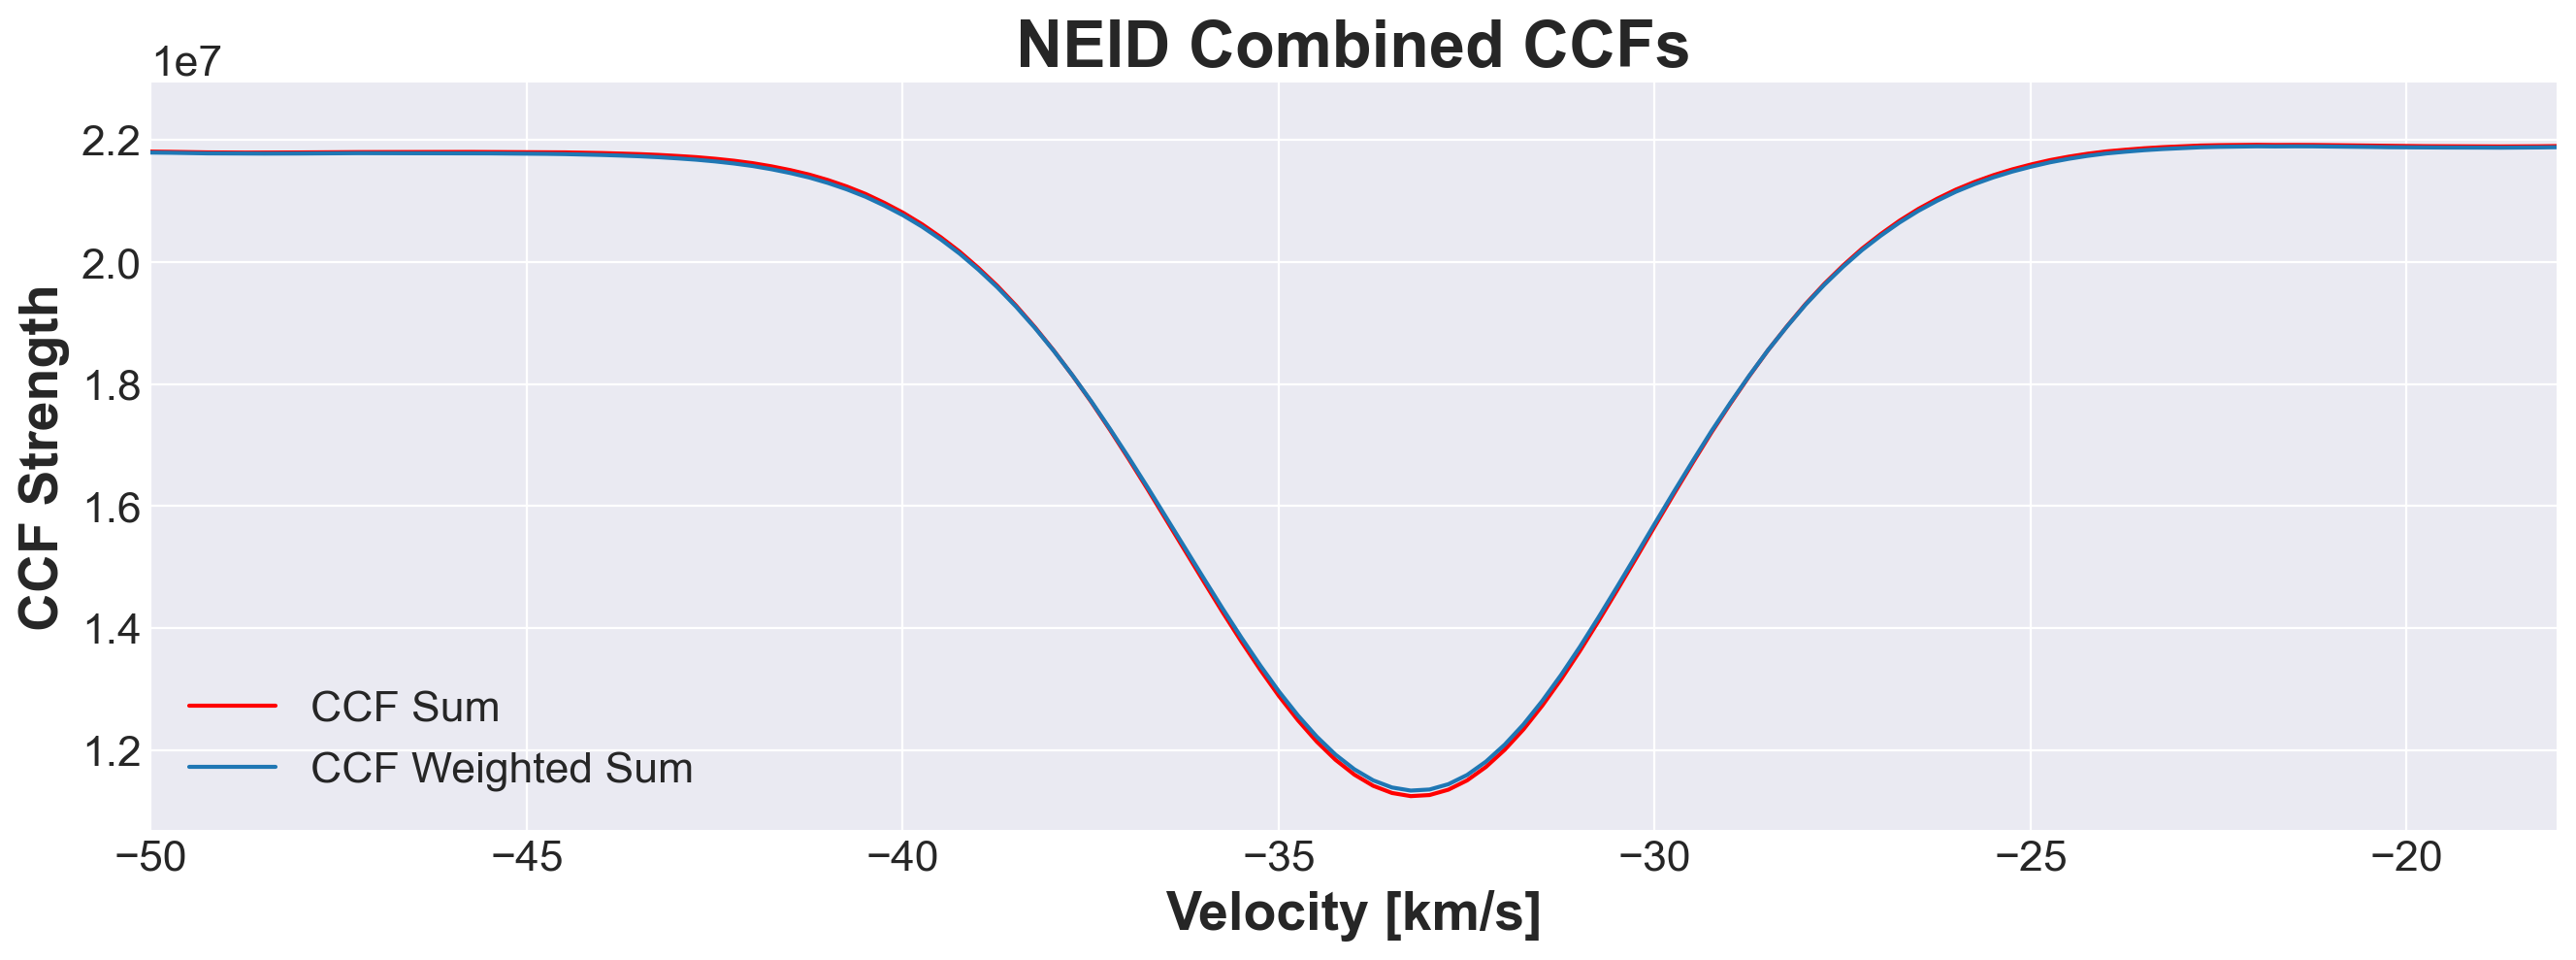

In [15]:
fig = plt.subplots(figsize=(16,5))
plt.plot(velocity_loop,ccfsum,c='r',label='CCF Sum')
plt.plot(velocity_loop,ccfmod,c='C0',label='CCF Weighted Sum')
plt.title('NEID Combined CCFs')
plt.xlabel('Velocity [km/s]')
plt.ylabel('CCF Strength')
plt.xlim(-50,-18)
plt.legend()
plt.show()

These are VERY similar but in our precision measurements, can make a big difference (if the observing conditions are variable or not very good).

Unless you are looking for chromatic (wavelength-dependent) behavior in the CCFs, you can skip the order CCFs and just work with the weighted sum CCF.

You could fit a Gaussian to the weighted sum CCF to get the final RV value of the epoch, or find this value in the header:

In [16]:
print('Radial velocity of this observation is {} km/s.'.format(hdul['CCFS'].header['CCFRVMOD']))
print('Time of this observation is {} BJD.'.format(hdul['CCFS'].header['CCFJDMOD']))

Radial velocity of this observation is -33.23011966224551 km/s.
Time of this observation is 2459372.877009301 BJD.


### 3. Shifting CCFs <a class="anchor" id="shiftccf"></a>

For certain science applications, you might want to shift the CCF. For example, you might want to zero out velocity of the star. This is easier than shifting the underlying spectrum since the CCF is much higher signal-to-noise, but it still has to be done carefully. Interpolation errors can easily overwhelm precision measurements on the shifted CCF.

In [17]:
# Make a standard grid onto which we will shift and upsample the CCF
master_loop = np.arange(-75,75,0.05)
ccfinterp = interp1d(velocity_loop - gamma_rv, ccfmod, kind='cubic')
shifted_ccf = ccfinterp(master_loop)

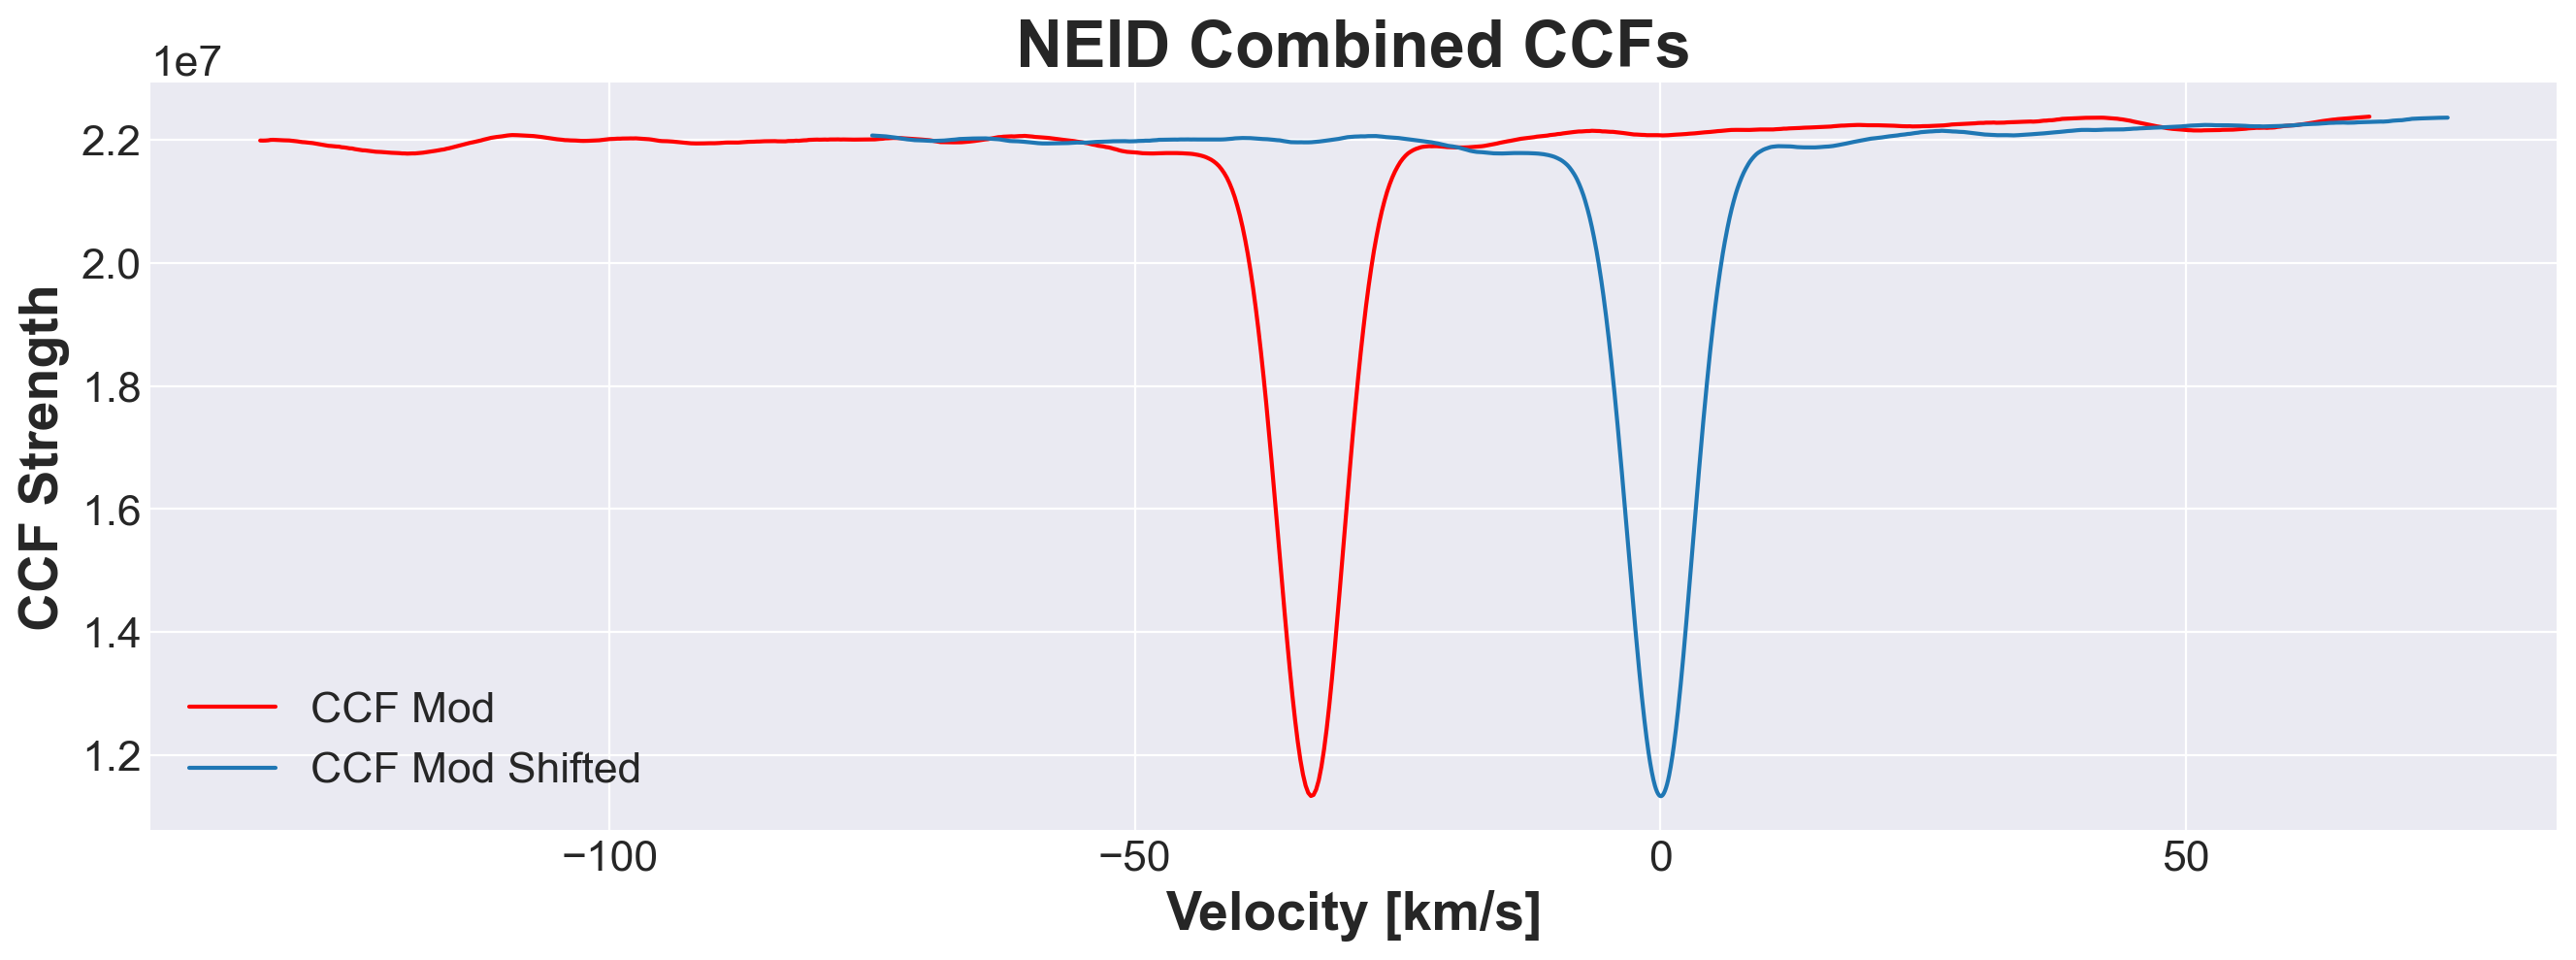

In [18]:
fig = plt.subplots(figsize=(16,5))
plt.plot(velocity_loop,ccfmod,c='r',label='CCF Mod')
plt.plot(master_loop,shifted_ccf,c='C0',label='CCF Mod Shifted')
plt.title('NEID Combined CCFs')
plt.xlabel('Velocity [km/s]')
plt.ylabel('CCF Strength')
#plt.xlim(-50,-18)
plt.legend()
plt.show()

Success! We have shifted the CCF to zero out the star RV.